# Converting image to Hough space and calculating the number of lines

Some inspiration and logic was taken from https://github.com/FienSoP.

In [185]:
import os 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
import math

In [9]:
%matplotlib inline

## Load sample image

In [107]:
# Help functions

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

def load_data(image_name):    
    '''
    Load images from the "faces_imgs" directory
    Images are in JPG and we convert it to gray scale images
    '''
    img = mpimg.imread(image_name)
    img = rgb2gray(img)
    
    return img

def visualize(img, format=None, gray=False):
    if img.shape[0] == 3:
        img = img.transpose(1,2,0)
    plt.imshow(img, format)
    plt.show()

In [108]:
sample_image_name = 'marker_cut_rgb_512.png'

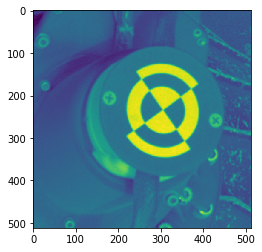

In [109]:
sample_image = load_data(sample_image_name)
sample_image_arr = np.array(sample_image)
visualize(sample_image)

## Hough space math background

A line in Cartesian form could be expressed in the equation:

*y = mx + b*

where: 

m = gradient or slope of the line (rise/run)   
b = y-intercept

![Example of two points with various intersections](hough_mb_parameter_space.png)

If we have two example points, for each point we can set different values of *m* and therefore obtain different intersections, and we can compute corresponding *b* values.

All points on a line in image space intersect at a common point in parameter space. This common point *(m, b)* represents the line in image space.
Unfortunately, the slope, *m*, is undefined when the line is vertical (division by 0!).
To overcome this, we use another parameter space, the hough space.

## Polar coordinate system

A line in Polar coordinate system could be expressed in the equation:

*ρ = x cos θ + y sin θ*

where:

*ρ (rho)* = distance from origin to the line. [-max_dist to max_dist].
          max_dist is the diagonal length of the image.  
*θ* = angle from origin to the line. [-90° to 90°]


## Algorithm steps

1. **Corner or edge detection**. We can use **Canny, Sobel or Adaptive Thresholding algorithm**. The result of this step is binary or grey image with zeros indicating non-edges and ones indicating edges. The result is now interpreted as our input image

2. **Rho range and Theta range creation.** ρ ranges from *-max_dist* to *+max_dist* where *max_dist* is the diagonal length of the input image (the number of diagonal entries in image matrix). θ ranges from *-90∘ to 90∘*. 

3. **Hough accumulator of θ vs ρ**. Is a 2D array with the number of rows equal to the number of ρ values and the number of columns equal to number of θ values.

4. **Accumulator voting**. For each of the edge points and for each of θ we find the nearest corresponding ρ valeu and increment it index in the accumulator. Each element in our accumulator matrix tells how many pixels contributed votes for line candidate with tuple of parameters (ρ, θ)

5. **Peak search**. Maximum values in the accumulator matrix indicate parameters of most probable lines in the image. Peaks could be found by applying some threshold.

## Convolution operator

Convolution is a simple mathematical operation which is fundamental to many common image processing operators. Convolution provides a way of multiplying together two arrays of numbers, generally of different sizes, but of the same dimensionality, to produce a third array of numbers of the same dimensionality. 

This can be used in image processing to implement operators whose output pixel values are simple linear combinations of certain input pixel values.

If the image has M rows and N columns, and the kernel has m rows and n columns, then the size of the output image will have *M - m + 1* rows, and *N - n + 1* columns.

## Canny Edge Detector (CED)

*The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works (C)*

The general algorithm goes in five steps:

- Noise reduction
- Image gradient calculation
- Non-maximum suppression (*optional*)
- Double threshold (*optional*)
- Edge tracking


The algorithm is based on grayscale images, so the input image should be grayscale

### Noise reduction

Since this algorithm is based on gradient calculation it is very sensitive to image noise and the **noise reduction** stage is crucial.
The easiest approach is to add Gaussian blur to the image to smooth it. We need to select the kernel size of the Gaussian Filter, which will set the amount of blur.

![Gaussian Kernel formula](gaussian_kernel_formula.png)

In [110]:
def gaussian_kernel(kernel_size, sigma = 1):
    '''
    Create a Gaussian Kernel of given size
    for applying blur to image
    '''
    
    kernel_size = int(kernel_size) // 2
    x, y = np.mgrid[-kernel_size:kernel_size+1, -kernel_size:kernel_size+1] 
    norm = 1 / (2.0 * np.pi * sigma**2)
    kernel = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * norm
    
    return kernel

### Gradient Calculation

Gradient calculation detects the edge intensity and direction by calculating the gradient of the whole image using edge detection operators.

*Edges correspond to a change of pixels’ intensity. To detect it, the easiest way is to apply filters that highlight this intensity change in both directions: horizontal (x) and vertical (y)*

After image smoothing phase the *Ix* and *Iy* are calculated. It could be implemented with Sobel Kernels *Kx* and *Ky*.

![Sobel Filters](sobel_filters.png)

![Magnitude](magnitude.png)

In [111]:
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(image, Kx)
    Iy = ndimage.filters.convolve(image, Ky)
    
    g = np.hypot(Ix, Iy)
    g = g / g.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (g, theta)

### Non-maximum suppression

This approach is used to have thin edges in our images. Non-thin edges could be encountered due to various reasons - one of them is blur. The princimple is quite simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with maximum value in the edge directions.

The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed.

The algorithm flow:

- Create zeros matrix of the same size as the original gradient matrix
- Identify the edge directin based on the angle value from the matrix of angles
- Check if the pixels in the same direction of the current processed pixel have higher intensity

In [112]:
def non_max_suppression(image, diagonal):
    '''
    Inputs and image and matrix of angles
    and outputs a matrix of thinned edges
    '''
    
    m, n = image.shape
    
    # Create zeros matrix of gradient size
    zer_proc = np.zeros((m,n), dtype = np.int32)
    
    # Calculate angles of the pixels
    angle = diagonal * 180. / np.pi
    
    # Supress zero angles
    angle[angle <0] += 180
    
    for i in range(1, m-1):
        for j in range(1, n-1):
            try :
                # Get the values of next and previous pixel in direction
                next_pixel = image[i, j+1]
                previous_pixel = image[i, j-1]
                
                #0°
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    next_pixel = image[i, j+1]
                    previous_pixel = image[i, j-1]
                    
                #45°
                elif (22.5 <= angle[i,j] < 67.5):
                    next_pixel = image[i+1, j-1]
                    previous_pixel = image[i-1, j+1]
                    
                #90°
                elif (67.5 <= angle[i,j] < 112.5):
                    next_pixel = image[i+1, j]
                    previous_pixel = image[i-1, j]
                    
                #135°
                elif (112.5 <= angle[i,j] < 157.5):
                    next_pixel = image[i-1, j-1]
                    previous_pixel = image[i+1, j+1]

                    
                if (image[i,j] >= next_pixel) and (image[i,j] >= previous_pixel):
                    zer_proc[i,j] = image[i,j]
                else:
                    zer_proc[i,j] = 0
                
            except IndexError:
                pass
            
    return zer_proc
                

### Double threshold

The main idea of double threshold is to identify three types of pixels: strong, weka and non-relevant. 

- **Strong pixels** - have very high intensity, compared to others, and will contributed to edge detection.
- **Weak pixels** - are something in mediocre of strong and non-relevant pixels. 
- **Non-relevant** - have very low intensity and therefore won't contribute to edge detection


So what is the idea of **double** threshold? We set two hyperparameters - **high threshold** and **low threshold**. 

- Pixels, that have intensity higher than high threshold are considered **strong**
- Pixels, that have intensity lower than low threshold are considered **non-relevant**
- All other pixels are considered **weak**

In [136]:
def double_threshold(image, low_threshold_ratio, high_threshold_ratio):
    '''
    Applies double threshold algorithm to image with
    given ratio and outputs processed image
    '''
    
    # Calculate the threshold intensity values for image
    high_threshold = image.max() * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio
    
    # Create resulting matrix - the same size as previously processed image
    m,n = image.shape
    res_matrix = np.zeros((m,n), dtype = np.int32)
    
    # Create matrices for weak and strong pixels
    weak_pixels = np.int32(25)
    strong_pixels = np.int32(255)
    
    # Find the indexes for corresponding pixels
    i_str, j_str = np.where(image >= high_threshold)
    i_low, j_low = np.where(image < low_threshold)
    i_weak, j_weak = np.where((image <= high_threshold) & (image >= low_threshold)) 
    
    res_matrix[i_str, j_str] = strong_pixels
    res_matrix[i_weak, j_weak] = weak_pixels
    
    return (res_matrix, weak_pixels, strong_pixels)   

### Hysteresis edge tracking

The final improvement step called the **Hysteresis** is used to transform weak pixels into strong ones if there are at least one strong pixel near the current processed weak one.

![Hysteresis](hysteresis.png)

In [142]:
def hysteresis(image, weak_pixels, strong_pixels):
    '''
    Gets an input image and checks pixel-by-pixel
    all surrounding pixels to be strong
    
    Outputs an converted image
    '''
    
    m,n = image.shape
    
    for i in range(1, m - 1):
        for j in range(1, n - 1):
            if(image[i,j] == weak_pixels):
                try:
                    # Check all possible options for surrounding pixels to be strong
                    if ((image[i+1, j-1] == strong_pixels) or 
                        (image[i+1, j] == strong_pixels) or 
                        (image[i+1, j+1] == strong_pixels) or 
                        (image[i, j-1] == strong_pixels) or 
                        (image[i, j+1] == strong_pixels) or 
                        (image[i-1, j-1] == strong_pixels) or 
                        (image[i-1, j] == strong_pixels) or
                        (image[i-1, j+1] == strong_pixels)):
                         
                        image[i, j] = strong_pixels
                    else:
                        image[i, j] = 0
                except IndexError:
                    pass
                
    return image  

In [202]:
def HoughLines(image):
    '''
    Takes an input image as numpy array after
    some transformation (Canny, Sobel, Adaptive thresholding)
    and returns thetas, rhos and accumulator
    '''
    
    # Rho range and Theta range creation
    
    width, height = image.shape[0], image.shape[1]
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    
    max_distance = np.ceil(np.sqrt(width * width + height * height))
    rhos = np.linspace(-max_distance, max_distance, max_distance * 2.0)
    
    # Calculate the sinus and cosinus of theta values
    
    theta_cos = np.cos(thetas)
    theta_sin = np.sin(thetas)
    
    # Create Hough accumulator
    accumulator_size = (int(2 * max_distance), len(thetas))
    accumulator = np.zeros(accumulator_size, dtype=np.uint64)
    
    # Edge indexes
    
    y_id, x_id = np.nonzero(image)
    
    # Accumulator voting
    
    # Go through every index of column indexes to edges
    
    processed_counter = 0
    print("Number of indexes %d" % len(x_id))
    
    for i in range(len(x_id)):
        
        x = x_id[i]
        y = y_id[i]
        
        # And vote through every theta
        for theta_i in range(len(thetas)):
            rho = int(round(x * theta_cos[theta_i] + y * theta_sin[theta_i]) + max_distance)
            accumulator[rho, theta_i] += 1
          
        processed_counter += 1
        print("Processed %d indexes" % processed_counter)
            
    return thetas, rhos, accumulator

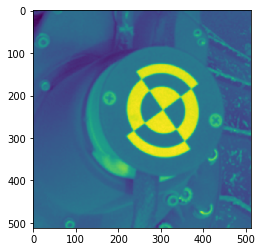

In [203]:
# Smooth the sample image (if needed)

smoothed_image = ndimage.filters.convolve(sample_image_arr, gaussian_kernel(10))
imgplot = plt.imshow(smoothed_image)

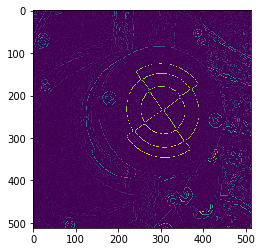

In [204]:
# Find the gradients and apply non-max suppression

grad_matrix, theta_matrix = sobel_filters(smoothed_image)
non_max_image = non_max_suppression(grad_matrix, theta_matrix)
imgplot = plt.imshow(non_max_image)

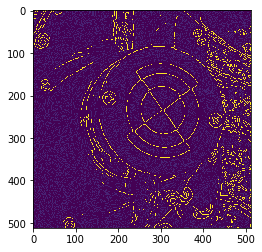

In [205]:
# Apply double thresholding

threshold_image, weak_pixels, strong_pixels = double_threshold(non_max_image, 0.05, 0.1)

imgplot = plt.imshow(threshold_image)

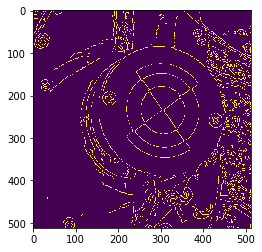

In [206]:
# Apply hysteresys search

hysteresys_img = hysteresis(threshold_image, weak_pixels, strong_pixels)

imgplot = plt.imshow(hysteresys_img)

We can see that image noise was decreased and the lines are visible much better now.

In [207]:
# Apply Hough space algorithm

accumulator, thetas, rhos = HoughLines(hysteresys_img)

c:\users\omisko\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  


Number of indexes 15396
Processed 1 indexes
Processed 2 indexes
Processed 3 indexes
Processed 4 indexes
Processed 5 indexes
Processed 6 indexes
Processed 7 indexes
Processed 8 indexes
Processed 9 indexes
Processed 10 indexes
Processed 11 indexes
Processed 12 indexes
Processed 13 indexes
Processed 14 indexes
Processed 15 indexes
Processed 16 indexes
Processed 17 indexes
Processed 18 indexes
Processed 19 indexes
Processed 20 indexes
Processed 21 indexes
Processed 22 indexes
Processed 23 indexes
Processed 24 indexes
Processed 25 indexes
Processed 26 indexes
Processed 27 indexes
Processed 28 indexes
Processed 29 indexes
Processed 30 indexes
Processed 31 indexes
Processed 32 indexes
Processed 33 indexes
Processed 34 indexes
Processed 35 indexes
Processed 36 indexes
Processed 37 indexes
Processed 38 indexes
Processed 39 indexes
Processed 40 indexes
Processed 41 indexes
Processed 42 indexes
Processed 43 indexes
Processed 44 indexes
Processed 45 indexes
Processed 46 indexes
Processed 47 indexe

Processed 811 indexes
Processed 812 indexes
Processed 813 indexes
Processed 814 indexes
Processed 815 indexes
Processed 816 indexes
Processed 817 indexes
Processed 818 indexes
Processed 819 indexes
Processed 820 indexes
Processed 821 indexes
Processed 822 indexes
Processed 823 indexes
Processed 824 indexes
Processed 825 indexes
Processed 826 indexes
Processed 827 indexes
Processed 828 indexes
Processed 829 indexes
Processed 830 indexes
Processed 831 indexes
Processed 832 indexes
Processed 833 indexes
Processed 834 indexes
Processed 835 indexes
Processed 836 indexes
Processed 837 indexes
Processed 838 indexes
Processed 839 indexes
Processed 840 indexes
Processed 841 indexes
Processed 842 indexes
Processed 843 indexes
Processed 844 indexes
Processed 845 indexes
Processed 846 indexes
Processed 847 indexes
Processed 848 indexes
Processed 849 indexes
Processed 850 indexes
Processed 851 indexes
Processed 852 indexes
Processed 853 indexes
Processed 854 indexes
Processed 855 indexes
Processed 

Processed 1468 indexes
Processed 1469 indexes
Processed 1470 indexes
Processed 1471 indexes
Processed 1472 indexes
Processed 1473 indexes
Processed 1474 indexes
Processed 1475 indexes
Processed 1476 indexes
Processed 1477 indexes
Processed 1478 indexes
Processed 1479 indexes
Processed 1480 indexes
Processed 1481 indexes
Processed 1482 indexes
Processed 1483 indexes
Processed 1484 indexes
Processed 1485 indexes
Processed 1486 indexes
Processed 1487 indexes
Processed 1488 indexes
Processed 1489 indexes
Processed 1490 indexes
Processed 1491 indexes
Processed 1492 indexes
Processed 1493 indexes
Processed 1494 indexes
Processed 1495 indexes
Processed 1496 indexes
Processed 1497 indexes
Processed 1498 indexes
Processed 1499 indexes
Processed 1500 indexes
Processed 1501 indexes
Processed 1502 indexes
Processed 1503 indexes
Processed 1504 indexes
Processed 1505 indexes
Processed 1506 indexes
Processed 1507 indexes
Processed 1508 indexes
Processed 1509 indexes
Processed 1510 indexes
Processed 1

Processed 1967 indexes
Processed 1968 indexes
Processed 1969 indexes
Processed 1970 indexes
Processed 1971 indexes
Processed 1972 indexes
Processed 1973 indexes
Processed 1974 indexes
Processed 1975 indexes
Processed 1976 indexes
Processed 1977 indexes
Processed 1978 indexes
Processed 1979 indexes
Processed 1980 indexes
Processed 1981 indexes
Processed 1982 indexes
Processed 1983 indexes
Processed 1984 indexes
Processed 1985 indexes
Processed 1986 indexes
Processed 1987 indexes
Processed 1988 indexes
Processed 1989 indexes
Processed 1990 indexes
Processed 1991 indexes
Processed 1992 indexes
Processed 1993 indexes
Processed 1994 indexes
Processed 1995 indexes
Processed 1996 indexes
Processed 1997 indexes
Processed 1998 indexes
Processed 1999 indexes
Processed 2000 indexes
Processed 2001 indexes
Processed 2002 indexes
Processed 2003 indexes
Processed 2004 indexes
Processed 2005 indexes
Processed 2006 indexes
Processed 2007 indexes
Processed 2008 indexes
Processed 2009 indexes
Processed 2

Processed 2466 indexes
Processed 2467 indexes
Processed 2468 indexes
Processed 2469 indexes
Processed 2470 indexes
Processed 2471 indexes
Processed 2472 indexes
Processed 2473 indexes
Processed 2474 indexes
Processed 2475 indexes
Processed 2476 indexes
Processed 2477 indexes
Processed 2478 indexes
Processed 2479 indexes
Processed 2480 indexes
Processed 2481 indexes
Processed 2482 indexes
Processed 2483 indexes
Processed 2484 indexes
Processed 2485 indexes
Processed 2486 indexes
Processed 2487 indexes
Processed 2488 indexes
Processed 2489 indexes
Processed 2490 indexes
Processed 2491 indexes
Processed 2492 indexes
Processed 2493 indexes
Processed 2494 indexes
Processed 2495 indexes
Processed 2496 indexes
Processed 2497 indexes
Processed 2498 indexes
Processed 2499 indexes
Processed 2500 indexes
Processed 2501 indexes
Processed 2502 indexes
Processed 2503 indexes
Processed 2504 indexes
Processed 2505 indexes
Processed 2506 indexes
Processed 2507 indexes
Processed 2508 indexes
Processed 2

Processed 2966 indexes
Processed 2967 indexes
Processed 2968 indexes
Processed 2969 indexes
Processed 2970 indexes
Processed 2971 indexes
Processed 2972 indexes
Processed 2973 indexes
Processed 2974 indexes
Processed 2975 indexes
Processed 2976 indexes
Processed 2977 indexes
Processed 2978 indexes
Processed 2979 indexes
Processed 2980 indexes
Processed 2981 indexes
Processed 2982 indexes
Processed 2983 indexes
Processed 2984 indexes
Processed 2985 indexes
Processed 2986 indexes
Processed 2987 indexes
Processed 2988 indexes
Processed 2989 indexes
Processed 2990 indexes
Processed 2991 indexes
Processed 2992 indexes
Processed 2993 indexes
Processed 2994 indexes
Processed 2995 indexes
Processed 2996 indexes
Processed 2997 indexes
Processed 2998 indexes
Processed 2999 indexes
Processed 3000 indexes
Processed 3001 indexes
Processed 3002 indexes
Processed 3003 indexes
Processed 3004 indexes
Processed 3005 indexes
Processed 3006 indexes
Processed 3007 indexes
Processed 3008 indexes
Processed 3

Processed 3465 indexes
Processed 3466 indexes
Processed 3467 indexes
Processed 3468 indexes
Processed 3469 indexes
Processed 3470 indexes
Processed 3471 indexes
Processed 3472 indexes
Processed 3473 indexes
Processed 3474 indexes
Processed 3475 indexes
Processed 3476 indexes
Processed 3477 indexes
Processed 3478 indexes
Processed 3479 indexes
Processed 3480 indexes
Processed 3481 indexes
Processed 3482 indexes
Processed 3483 indexes
Processed 3484 indexes
Processed 3485 indexes
Processed 3486 indexes
Processed 3487 indexes
Processed 3488 indexes
Processed 3489 indexes
Processed 3490 indexes
Processed 3491 indexes
Processed 3492 indexes
Processed 3493 indexes
Processed 3494 indexes
Processed 3495 indexes
Processed 3496 indexes
Processed 3497 indexes
Processed 3498 indexes
Processed 3499 indexes
Processed 3500 indexes
Processed 3501 indexes
Processed 3502 indexes
Processed 3503 indexes
Processed 3504 indexes
Processed 3505 indexes
Processed 3506 indexes
Processed 3507 indexes
Processed 3

Processed 3965 indexes
Processed 3966 indexes
Processed 3967 indexes
Processed 3968 indexes
Processed 3969 indexes
Processed 3970 indexes
Processed 3971 indexes
Processed 3972 indexes
Processed 3973 indexes
Processed 3974 indexes
Processed 3975 indexes
Processed 3976 indexes
Processed 3977 indexes
Processed 3978 indexes
Processed 3979 indexes
Processed 3980 indexes
Processed 3981 indexes
Processed 3982 indexes
Processed 3983 indexes
Processed 3984 indexes
Processed 3985 indexes
Processed 3986 indexes
Processed 3987 indexes
Processed 3988 indexes
Processed 3989 indexes
Processed 3990 indexes
Processed 3991 indexes
Processed 3992 indexes
Processed 3993 indexes
Processed 3994 indexes
Processed 3995 indexes
Processed 3996 indexes
Processed 3997 indexes
Processed 3998 indexes
Processed 3999 indexes
Processed 4000 indexes
Processed 4001 indexes
Processed 4002 indexes
Processed 4003 indexes
Processed 4004 indexes
Processed 4005 indexes
Processed 4006 indexes
Processed 4007 indexes
Processed 4

Processed 4964 indexes
Processed 4965 indexes
Processed 4966 indexes
Processed 4967 indexes
Processed 4968 indexes
Processed 4969 indexes
Processed 4970 indexes
Processed 4971 indexes
Processed 4972 indexes
Processed 4973 indexes
Processed 4974 indexes
Processed 4975 indexes
Processed 4976 indexes
Processed 4977 indexes
Processed 4978 indexes
Processed 4979 indexes
Processed 4980 indexes
Processed 4981 indexes
Processed 4982 indexes
Processed 4983 indexes
Processed 4984 indexes
Processed 4985 indexes
Processed 4986 indexes
Processed 4987 indexes
Processed 4988 indexes
Processed 4989 indexes
Processed 4990 indexes
Processed 4991 indexes
Processed 4992 indexes
Processed 4993 indexes
Processed 4994 indexes
Processed 4995 indexes
Processed 4996 indexes
Processed 4997 indexes
Processed 4998 indexes
Processed 4999 indexes
Processed 5000 indexes
Processed 5001 indexes
Processed 5002 indexes
Processed 5003 indexes
Processed 5004 indexes
Processed 5005 indexes
Processed 5006 indexes
Processed 5

Processed 5464 indexes
Processed 5465 indexes
Processed 5466 indexes
Processed 5467 indexes
Processed 5468 indexes
Processed 5469 indexes
Processed 5470 indexes
Processed 5471 indexes
Processed 5472 indexes
Processed 5473 indexes
Processed 5474 indexes
Processed 5475 indexes
Processed 5476 indexes
Processed 5477 indexes
Processed 5478 indexes
Processed 5479 indexes
Processed 5480 indexes
Processed 5481 indexes
Processed 5482 indexes
Processed 5483 indexes
Processed 5484 indexes
Processed 5485 indexes
Processed 5486 indexes
Processed 5487 indexes
Processed 5488 indexes
Processed 5489 indexes
Processed 5490 indexes
Processed 5491 indexes
Processed 5492 indexes
Processed 5493 indexes
Processed 5494 indexes
Processed 5495 indexes
Processed 5496 indexes
Processed 5497 indexes
Processed 5498 indexes
Processed 5499 indexes
Processed 5500 indexes
Processed 5501 indexes
Processed 5502 indexes
Processed 5503 indexes
Processed 5504 indexes
Processed 5505 indexes
Processed 5506 indexes
Processed 5

Processed 5963 indexes
Processed 5964 indexes
Processed 5965 indexes
Processed 5966 indexes
Processed 5967 indexes
Processed 5968 indexes
Processed 5969 indexes
Processed 5970 indexes
Processed 5971 indexes
Processed 5972 indexes
Processed 5973 indexes
Processed 5974 indexes
Processed 5975 indexes
Processed 5976 indexes
Processed 5977 indexes
Processed 5978 indexes
Processed 5979 indexes
Processed 5980 indexes
Processed 5981 indexes
Processed 5982 indexes
Processed 5983 indexes
Processed 5984 indexes
Processed 5985 indexes
Processed 5986 indexes
Processed 5987 indexes
Processed 5988 indexes
Processed 5989 indexes
Processed 5990 indexes
Processed 5991 indexes
Processed 5992 indexes
Processed 5993 indexes
Processed 5994 indexes
Processed 5995 indexes
Processed 5996 indexes
Processed 5997 indexes
Processed 5998 indexes
Processed 5999 indexes
Processed 6000 indexes
Processed 6001 indexes
Processed 6002 indexes
Processed 6003 indexes
Processed 6004 indexes
Processed 6005 indexes
Processed 6

Processed 6463 indexes
Processed 6464 indexes
Processed 6465 indexes
Processed 6466 indexes
Processed 6467 indexes
Processed 6468 indexes
Processed 6469 indexes
Processed 6470 indexes
Processed 6471 indexes
Processed 6472 indexes
Processed 6473 indexes
Processed 6474 indexes
Processed 6475 indexes
Processed 6476 indexes
Processed 6477 indexes
Processed 6478 indexes
Processed 6479 indexes
Processed 6480 indexes
Processed 6481 indexes
Processed 6482 indexes
Processed 6483 indexes
Processed 6484 indexes
Processed 6485 indexes
Processed 6486 indexes
Processed 6487 indexes
Processed 6488 indexes
Processed 6489 indexes
Processed 6490 indexes
Processed 6491 indexes
Processed 6492 indexes
Processed 6493 indexes
Processed 6494 indexes
Processed 6495 indexes
Processed 6496 indexes
Processed 6497 indexes
Processed 6498 indexes
Processed 6499 indexes
Processed 6500 indexes
Processed 6501 indexes
Processed 6502 indexes
Processed 6503 indexes
Processed 6504 indexes
Processed 6505 indexes
Processed 6

Processed 6962 indexes
Processed 6963 indexes
Processed 6964 indexes
Processed 6965 indexes
Processed 6966 indexes
Processed 6967 indexes
Processed 6968 indexes
Processed 6969 indexes
Processed 6970 indexes
Processed 6971 indexes
Processed 6972 indexes
Processed 6973 indexes
Processed 6974 indexes
Processed 6975 indexes
Processed 6976 indexes
Processed 6977 indexes
Processed 6978 indexes
Processed 6979 indexes
Processed 6980 indexes
Processed 6981 indexes
Processed 6982 indexes
Processed 6983 indexes
Processed 6984 indexes
Processed 6985 indexes
Processed 6986 indexes
Processed 6987 indexes
Processed 6988 indexes
Processed 6989 indexes
Processed 6990 indexes
Processed 6991 indexes
Processed 6992 indexes
Processed 6993 indexes
Processed 6994 indexes
Processed 6995 indexes
Processed 6996 indexes
Processed 6997 indexes
Processed 6998 indexes
Processed 6999 indexes
Processed 7000 indexes
Processed 7001 indexes
Processed 7002 indexes
Processed 7003 indexes
Processed 7004 indexes
Processed 7

Processed 7462 indexes
Processed 7463 indexes
Processed 7464 indexes
Processed 7465 indexes
Processed 7466 indexes
Processed 7467 indexes
Processed 7468 indexes
Processed 7469 indexes
Processed 7470 indexes
Processed 7471 indexes
Processed 7472 indexes
Processed 7473 indexes
Processed 7474 indexes
Processed 7475 indexes
Processed 7476 indexes
Processed 7477 indexes
Processed 7478 indexes
Processed 7479 indexes
Processed 7480 indexes
Processed 7481 indexes
Processed 7482 indexes
Processed 7483 indexes
Processed 7484 indexes
Processed 7485 indexes
Processed 7486 indexes
Processed 7487 indexes
Processed 7488 indexes
Processed 7489 indexes
Processed 7490 indexes
Processed 7491 indexes
Processed 7492 indexes
Processed 7493 indexes
Processed 7494 indexes
Processed 7495 indexes
Processed 7496 indexes
Processed 7497 indexes
Processed 7498 indexes
Processed 7499 indexes
Processed 7500 indexes
Processed 7501 indexes
Processed 7502 indexes
Processed 7503 indexes
Processed 7504 indexes
Processed 7

Processed 7961 indexes
Processed 7962 indexes
Processed 7963 indexes
Processed 7964 indexes
Processed 7965 indexes
Processed 7966 indexes
Processed 7967 indexes
Processed 7968 indexes
Processed 7969 indexes
Processed 7970 indexes
Processed 7971 indexes
Processed 7972 indexes
Processed 7973 indexes
Processed 7974 indexes
Processed 7975 indexes
Processed 7976 indexes
Processed 7977 indexes
Processed 7978 indexes
Processed 7979 indexes
Processed 7980 indexes
Processed 7981 indexes
Processed 7982 indexes
Processed 7983 indexes
Processed 7984 indexes
Processed 7985 indexes
Processed 7986 indexes
Processed 7987 indexes
Processed 7988 indexes
Processed 7989 indexes
Processed 7990 indexes
Processed 7991 indexes
Processed 7992 indexes
Processed 7993 indexes
Processed 7994 indexes
Processed 7995 indexes
Processed 7996 indexes
Processed 7997 indexes
Processed 7998 indexes
Processed 7999 indexes
Processed 8000 indexes
Processed 8001 indexes
Processed 8002 indexes
Processed 8003 indexes
Processed 8

Processed 8461 indexes
Processed 8462 indexes
Processed 8463 indexes
Processed 8464 indexes
Processed 8465 indexes
Processed 8466 indexes
Processed 8467 indexes
Processed 8468 indexes
Processed 8469 indexes
Processed 8470 indexes
Processed 8471 indexes
Processed 8472 indexes
Processed 8473 indexes
Processed 8474 indexes
Processed 8475 indexes
Processed 8476 indexes
Processed 8477 indexes
Processed 8478 indexes
Processed 8479 indexes
Processed 8480 indexes
Processed 8481 indexes
Processed 8482 indexes
Processed 8483 indexes
Processed 8484 indexes
Processed 8485 indexes
Processed 8486 indexes
Processed 8487 indexes
Processed 8488 indexes
Processed 8489 indexes
Processed 8490 indexes
Processed 8491 indexes
Processed 8492 indexes
Processed 8493 indexes
Processed 8494 indexes
Processed 8495 indexes
Processed 8496 indexes
Processed 8497 indexes
Processed 8498 indexes
Processed 8499 indexes
Processed 8500 indexes
Processed 8501 indexes
Processed 8502 indexes
Processed 8503 indexes
Processed 8

Processed 9460 indexes
Processed 9461 indexes
Processed 9462 indexes
Processed 9463 indexes
Processed 9464 indexes
Processed 9465 indexes
Processed 9466 indexes
Processed 9467 indexes
Processed 9468 indexes
Processed 9469 indexes
Processed 9470 indexes
Processed 9471 indexes
Processed 9472 indexes
Processed 9473 indexes
Processed 9474 indexes
Processed 9475 indexes
Processed 9476 indexes
Processed 9477 indexes
Processed 9478 indexes
Processed 9479 indexes
Processed 9480 indexes
Processed 9481 indexes
Processed 9482 indexes
Processed 9483 indexes
Processed 9484 indexes
Processed 9485 indexes
Processed 9486 indexes
Processed 9487 indexes
Processed 9488 indexes
Processed 9489 indexes
Processed 9490 indexes
Processed 9491 indexes
Processed 9492 indexes
Processed 9493 indexes
Processed 9494 indexes
Processed 9495 indexes
Processed 9496 indexes
Processed 9497 indexes
Processed 9498 indexes
Processed 9499 indexes
Processed 9500 indexes
Processed 9501 indexes
Processed 9502 indexes
Processed 9

Processed 9960 indexes
Processed 9961 indexes
Processed 9962 indexes
Processed 9963 indexes
Processed 9964 indexes
Processed 9965 indexes
Processed 9966 indexes
Processed 9967 indexes
Processed 9968 indexes
Processed 9969 indexes
Processed 9970 indexes
Processed 9971 indexes
Processed 9972 indexes
Processed 9973 indexes
Processed 9974 indexes
Processed 9975 indexes
Processed 9976 indexes
Processed 9977 indexes
Processed 9978 indexes
Processed 9979 indexes
Processed 9980 indexes
Processed 9981 indexes
Processed 9982 indexes
Processed 9983 indexes
Processed 9984 indexes
Processed 9985 indexes
Processed 9986 indexes
Processed 9987 indexes
Processed 9988 indexes
Processed 9989 indexes
Processed 9990 indexes
Processed 9991 indexes
Processed 9992 indexes
Processed 9993 indexes
Processed 9994 indexes
Processed 9995 indexes
Processed 9996 indexes
Processed 9997 indexes
Processed 9998 indexes
Processed 9999 indexes
Processed 10000 indexes
Processed 10001 indexes
Processed 10002 indexes
Processe

Processed 10459 indexes
Processed 10460 indexes
Processed 10461 indexes
Processed 10462 indexes
Processed 10463 indexes
Processed 10464 indexes
Processed 10465 indexes
Processed 10466 indexes
Processed 10467 indexes
Processed 10468 indexes
Processed 10469 indexes
Processed 10470 indexes
Processed 10471 indexes
Processed 10472 indexes
Processed 10473 indexes
Processed 10474 indexes
Processed 10475 indexes
Processed 10476 indexes
Processed 10477 indexes
Processed 10478 indexes
Processed 10479 indexes
Processed 10480 indexes
Processed 10481 indexes
Processed 10482 indexes
Processed 10483 indexes
Processed 10484 indexes
Processed 10485 indexes
Processed 10486 indexes
Processed 10487 indexes
Processed 10488 indexes
Processed 10489 indexes
Processed 10490 indexes
Processed 10491 indexes
Processed 10492 indexes
Processed 10493 indexes
Processed 10494 indexes
Processed 10495 indexes
Processed 10496 indexes
Processed 10497 indexes
Processed 10498 indexes
Processed 10499 indexes
Processed 10500 

Processed 11459 indexes
Processed 11460 indexes
Processed 11461 indexes
Processed 11462 indexes
Processed 11463 indexes
Processed 11464 indexes
Processed 11465 indexes
Processed 11466 indexes
Processed 11467 indexes
Processed 11468 indexes
Processed 11469 indexes
Processed 11470 indexes
Processed 11471 indexes
Processed 11472 indexes
Processed 11473 indexes
Processed 11474 indexes
Processed 11475 indexes
Processed 11476 indexes
Processed 11477 indexes
Processed 11478 indexes
Processed 11479 indexes
Processed 11480 indexes
Processed 11481 indexes
Processed 11482 indexes
Processed 11483 indexes
Processed 11484 indexes
Processed 11485 indexes
Processed 11486 indexes
Processed 11487 indexes
Processed 11488 indexes
Processed 11489 indexes
Processed 11490 indexes
Processed 11491 indexes
Processed 11492 indexes
Processed 11493 indexes
Processed 11494 indexes
Processed 11495 indexes
Processed 11496 indexes
Processed 11497 indexes
Processed 11498 indexes
Processed 11499 indexes
Processed 11500 

Processed 11958 indexes
Processed 11959 indexes
Processed 11960 indexes
Processed 11961 indexes
Processed 11962 indexes
Processed 11963 indexes
Processed 11964 indexes
Processed 11965 indexes
Processed 11966 indexes
Processed 11967 indexes
Processed 11968 indexes
Processed 11969 indexes
Processed 11970 indexes
Processed 11971 indexes
Processed 11972 indexes
Processed 11973 indexes
Processed 11974 indexes
Processed 11975 indexes
Processed 11976 indexes
Processed 11977 indexes
Processed 11978 indexes
Processed 11979 indexes
Processed 11980 indexes
Processed 11981 indexes
Processed 11982 indexes
Processed 11983 indexes
Processed 11984 indexes
Processed 11985 indexes
Processed 11986 indexes
Processed 11987 indexes
Processed 11988 indexes
Processed 11989 indexes
Processed 11990 indexes
Processed 11991 indexes
Processed 11992 indexes
Processed 11993 indexes
Processed 11994 indexes
Processed 11995 indexes
Processed 11996 indexes
Processed 11997 indexes
Processed 11998 indexes
Processed 11999 

Processed 12458 indexes
Processed 12459 indexes
Processed 12460 indexes
Processed 12461 indexes
Processed 12462 indexes
Processed 12463 indexes
Processed 12464 indexes
Processed 12465 indexes
Processed 12466 indexes
Processed 12467 indexes
Processed 12468 indexes
Processed 12469 indexes
Processed 12470 indexes
Processed 12471 indexes
Processed 12472 indexes
Processed 12473 indexes
Processed 12474 indexes
Processed 12475 indexes
Processed 12476 indexes
Processed 12477 indexes
Processed 12478 indexes
Processed 12479 indexes
Processed 12480 indexes
Processed 12481 indexes
Processed 12482 indexes
Processed 12483 indexes
Processed 12484 indexes
Processed 12485 indexes
Processed 12486 indexes
Processed 12487 indexes
Processed 12488 indexes
Processed 12489 indexes
Processed 12490 indexes
Processed 12491 indexes
Processed 12492 indexes
Processed 12493 indexes
Processed 12494 indexes
Processed 12495 indexes
Processed 12496 indexes
Processed 12497 indexes
Processed 12498 indexes
Processed 12499 

Processed 12957 indexes
Processed 12958 indexes
Processed 12959 indexes
Processed 12960 indexes
Processed 12961 indexes
Processed 12962 indexes
Processed 12963 indexes
Processed 12964 indexes
Processed 12965 indexes
Processed 12966 indexes
Processed 12967 indexes
Processed 12968 indexes
Processed 12969 indexes
Processed 12970 indexes
Processed 12971 indexes
Processed 12972 indexes
Processed 12973 indexes
Processed 12974 indexes
Processed 12975 indexes
Processed 12976 indexes
Processed 12977 indexes
Processed 12978 indexes
Processed 12979 indexes
Processed 12980 indexes
Processed 12981 indexes
Processed 12982 indexes
Processed 12983 indexes
Processed 12984 indexes
Processed 12985 indexes
Processed 12986 indexes
Processed 12987 indexes
Processed 12988 indexes
Processed 12989 indexes
Processed 12990 indexes
Processed 12991 indexes
Processed 12992 indexes
Processed 12993 indexes
Processed 12994 indexes
Processed 12995 indexes
Processed 12996 indexes
Processed 12997 indexes
Processed 12998 

Processed 13957 indexes
Processed 13958 indexes
Processed 13959 indexes
Processed 13960 indexes
Processed 13961 indexes
Processed 13962 indexes
Processed 13963 indexes
Processed 13964 indexes
Processed 13965 indexes
Processed 13966 indexes
Processed 13967 indexes
Processed 13968 indexes
Processed 13969 indexes
Processed 13970 indexes
Processed 13971 indexes
Processed 13972 indexes
Processed 13973 indexes
Processed 13974 indexes
Processed 13975 indexes
Processed 13976 indexes
Processed 13977 indexes
Processed 13978 indexes
Processed 13979 indexes
Processed 13980 indexes
Processed 13981 indexes
Processed 13982 indexes
Processed 13983 indexes
Processed 13984 indexes
Processed 13985 indexes
Processed 13986 indexes
Processed 13987 indexes
Processed 13988 indexes
Processed 13989 indexes
Processed 13990 indexes
Processed 13991 indexes
Processed 13992 indexes
Processed 13993 indexes
Processed 13994 indexes
Processed 13995 indexes
Processed 13996 indexes
Processed 13997 indexes
Processed 13998 

Processed 14456 indexes
Processed 14457 indexes
Processed 14458 indexes
Processed 14459 indexes
Processed 14460 indexes
Processed 14461 indexes
Processed 14462 indexes
Processed 14463 indexes
Processed 14464 indexes
Processed 14465 indexes
Processed 14466 indexes
Processed 14467 indexes
Processed 14468 indexes
Processed 14469 indexes
Processed 14470 indexes
Processed 14471 indexes
Processed 14472 indexes
Processed 14473 indexes
Processed 14474 indexes
Processed 14475 indexes
Processed 14476 indexes
Processed 14477 indexes
Processed 14478 indexes
Processed 14479 indexes
Processed 14480 indexes
Processed 14481 indexes
Processed 14482 indexes
Processed 14483 indexes
Processed 14484 indexes
Processed 14485 indexes
Processed 14486 indexes
Processed 14487 indexes
Processed 14488 indexes
Processed 14489 indexes
Processed 14490 indexes
Processed 14491 indexes
Processed 14492 indexes
Processed 14493 indexes
Processed 14494 indexes
Processed 14495 indexes
Processed 14496 indexes
Processed 14497 

Processed 14956 indexes
Processed 14957 indexes
Processed 14958 indexes
Processed 14959 indexes
Processed 14960 indexes
Processed 14961 indexes
Processed 14962 indexes
Processed 14963 indexes
Processed 14964 indexes
Processed 14965 indexes
Processed 14966 indexes
Processed 14967 indexes
Processed 14968 indexes
Processed 14969 indexes
Processed 14970 indexes
Processed 14971 indexes
Processed 14972 indexes
Processed 14973 indexes
Processed 14974 indexes
Processed 14975 indexes
Processed 14976 indexes
Processed 14977 indexes
Processed 14978 indexes
Processed 14979 indexes
Processed 14980 indexes
Processed 14981 indexes
Processed 14982 indexes
Processed 14983 indexes
Processed 14984 indexes
Processed 14985 indexes
Processed 14986 indexes
Processed 14987 indexes
Processed 14988 indexes
Processed 14989 indexes
Processed 14990 indexes
Processed 14991 indexes
Processed 14992 indexes
Processed 14993 indexes
Processed 14994 indexes
Processed 14995 indexes
Processed 14996 indexes
Processed 14997 

In [213]:
# Easiest peak finding based on max votes
print(len(thetas))
print(len(rhos))
print(len(accumulator))

1450
1450
180
